# PRUEBAS DE CÓDIGO

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
import cv2
from scipy import fftpack as fft

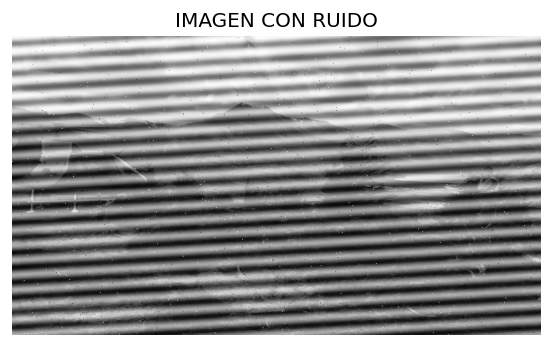

In [4]:
im_ori = cv2.imread(".images/o_ruido.jpg")
frame_ruido = cv2.cvtColor(im_ori, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.set_title('IMAGEN CON RUIDO')
ax.imshow(frame_ruido,cmap=plt.cm.Greys_r)
ax.axis('off');

* Tipos de Ruido:
        - Impulsivo(Sal y pimienta)
        - Periódico

Eliminamos el ruido impulsivo(sal y pimienta)

In [5]:
frame_limpio = cv2.medianBlur(frame_ruido, 5)

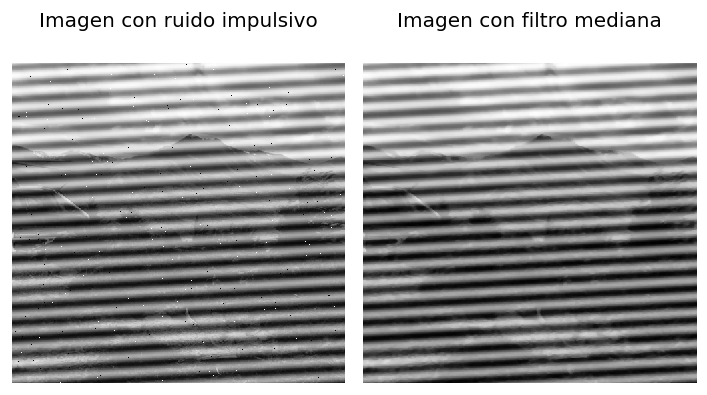

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(frame_ruido[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(frame_limpio[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Imagen con filtro mediana')
ax[1].axis('off');

Eliminamos el ruido periódico utilizando una máscara en frecuencia

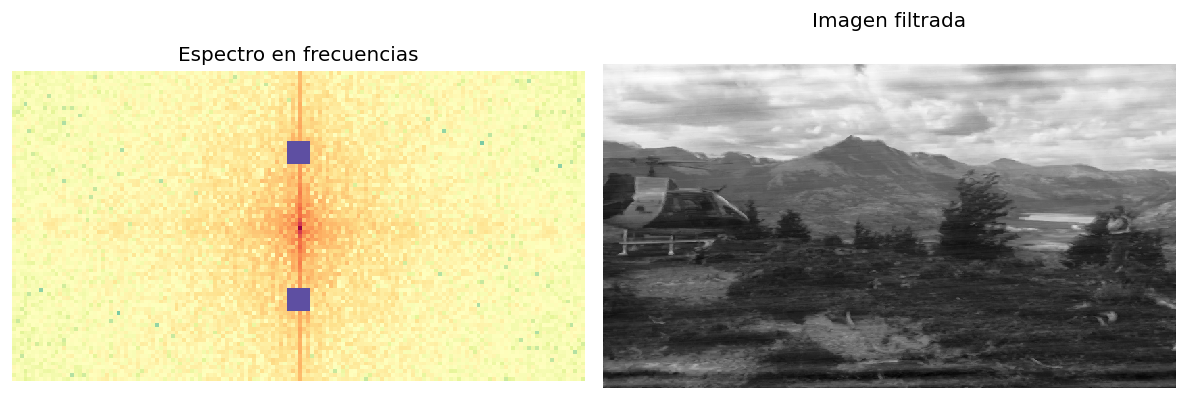

In [7]:
def create_mask(dims, frequency, size=3):
    freq_int = int(frequency*dims[0])
    mask = np.ones(shape=(dims[0], dims[1]))
    mask[dims[0]//2-size-freq_int:dims[0]//2+size-freq_int, 
         dims[1]//2-size:dims[1]//2+size] = 0 
    mask[dims[0]//2-size+freq_int:dims[0]//2+size+freq_int, 
          dims[1]//2-size:dims[1]//2+size] = 0
    return mask


freq_x = fft.fftshift(fft.fftfreq(n=frame_limpio.shape[1]))
freq_y = fft.fftshift(fft.fftfreq(n=frame_limpio.shape[0]))

S_img = fft.fftshift(fft.fft2(frame_limpio))
espectro_filtrado = S_img*create_mask(S_img.shape, 0.04)   
# Reconstrucción
img_reconstructed = np.real(fft.ifft2(fft.ifftshift(espectro_filtrado)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
#ax[0].matshow(frame_limpio, cmap=plt.cm.Greys_r) 
#ax[0].axis('off');
ax[0].imshow(np.log(1+np.abs(espectro_filtrado))[200:-200, 350:-350], cmap=plt.cm.Spectral_r)
ax[0].set_title("Espectro en frecuencias")
ax[0].axis('off');
ax[1].matshow(img_reconstructed, cmap=plt.cm.Greys_r)
ax[1].set_title("Imagen filtrada")
ax[1].axis('off');

In [8]:
frame = img_reconstructed

----

### Transformación

In [9]:
frame_size = frame.shape
dct_matrix = np.zeros(shape=frame_size)

DCT2 = lambda g, norm='ortho': fft.dct(fft.dct(g, axis=0, norm=norm), axis=1, norm=norm)
# Se recorre el frame en bloques de 8x8
for i in range(0, frame_size[0], 8):
    for j in range(0, frame_size[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = DCT2(frame[i:(i+8),j:(j+8)])

In [10]:
#print("dct_matrix: %s" %(dct_matrix))
#print("Tamaño dct_matrix: %s" %(repr(dct_matrix.shape)))
#print("Tipo dct_mattrix  : %s" %(dct_matrix.dtype))

In [11]:
frame_transformado = dct_matrix
#print(frame_transformado)

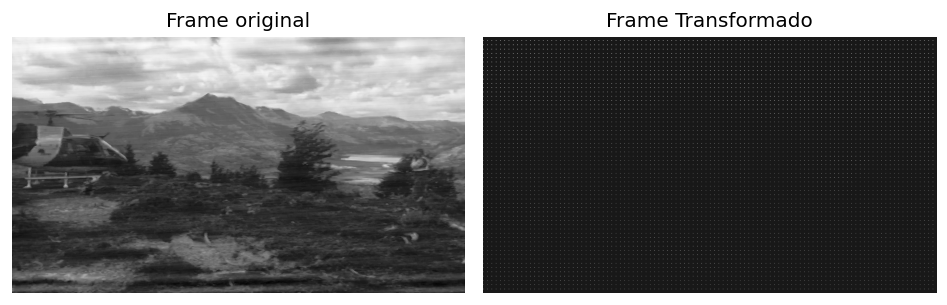

In [12]:
fig, ax = plt.subplots(1,2,figsize=(8, 3), tight_layout=True)
ax[0].imshow(frame,  cmap=plt.cm.Greys_r)
ax[0].set_title('Frame original')
ax[0].axis('off');

ax[1].imshow(frame_transformado, cmap=plt.cm.Greys_r)
ax[1].set_title('Frame Transformado')
ax[1].axis('off');

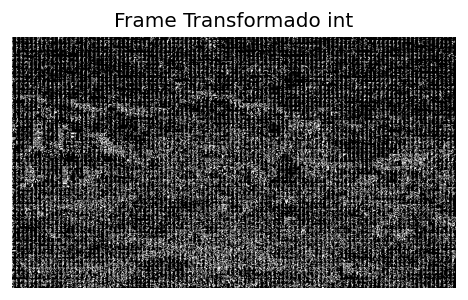

In [13]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(np.uint8(frame_transformado), cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

----

### Cuantización 

In [14]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

In [15]:
frame_size = frame_transformado.shape
im_dct = np.zeros(shape=frame_size)
# nnz = np.zeros(dct_matrix.shape) #
#porcentaje de cuantizacion?
IDCT2 = lambda G, norm='ortho': fft.idct( fft.idct(G, axis=0, norm=norm), axis=1, norm=norm)
porcentaje = 50
if (porcentaje < 50):
    S = 5000/porcentaje
else:
    S = 200 - 2*porcentaje

Q_dyn = np.floor((S*Q + 50) / 100);
Q_dyn[Q_dyn == 0] = 1 
for i in range(0, frame_size[0], 8):
    for j in range(0, frame_size[1], 8):
        quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn)
        im_dct[i:(i+8),j:(j+8)] = IDCT2(quant)
            

#frame = np.uint8(im_dct)

In [16]:
#print("im_dct: %s" %(im_dct))
#print("Tamaño im_dct: %s" %(repr(im_dct.shape)))
#print("Tipo im_dct  : %s" %(im_dct.dtype))

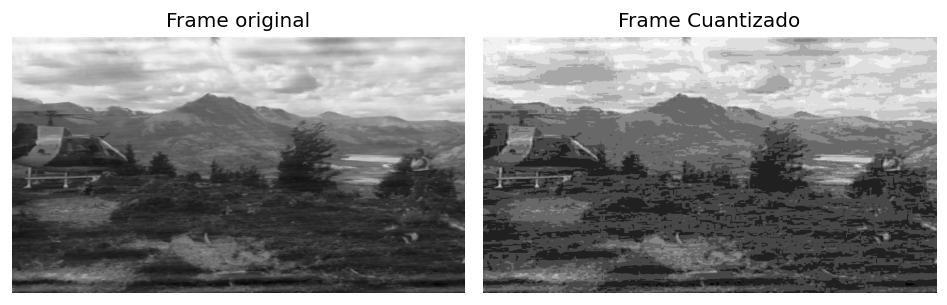

In [17]:
fig, ax = plt.subplots(1,2,figsize=(8, 3), tight_layout=True)
ax[0].imshow(frame,  cmap=plt.cm.Greys_r)
ax[0].set_title('Frame original')
ax[0].axis('off');

ax[1].imshow(np.uint8(im_dct), cmap=plt.cm.Greys_r)
ax[1].set_title('Frame Cuantizado')
ax[1].axis('off');

# Dendograma (O como se llame)

Se agrega esta linea de código antes del "return frame" en la función code(frame)

~~~python
with open('informe/infovector.txt', 'a') as f:
    np.savetxt(f,frame_ct, fmt='%i')    
~~~

Lo anterior generará un archivo de texto con toda la información de cada frame del video. Esto con el fin de realizar el dendograma

Una vez que finalizó el código anterior, procedemos a borrarlo del código y a hacer pruebas con el nuevo archivo que tenemos. El "infovector.txt"

Cargamos el infovector a una nueva variable

In [18]:
vector = np.loadtxt('infovector.txt')

In [19]:
vector = vector.astype(np.float64)

array([[238.,  -3.,   1., ...,   0.,   0.,   0.],
       [  2.,   0.,   0., ...,   0.,   0.,   0.],
       [ -1.,   1.,   0., ...,   0.,   0.,   0.],
       ...,
       [  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [41]:
vector = vector.ravel()

In [39]:
RESPALDO = vector

Generamos el dendograma

In [44]:
from collections import Counter
#Counter(texto).most_common()

In [45]:
# Implemetación adaptada de https://rosettacode.org/wiki/Huffman_coding#Python
import heapq
dendograma = [[frequencia/len(vector), [simbolo, ""]] for simbolo, frequencia in Counter(vector).items()]
heapq.heapify(dendograma)
while len(dendograma) > 1:
    lo = heapq.heappop(dendograma)
    hi = heapq.heappop(dendograma)
    for codigo in lo[1:]:
        codigo[1] = '0' + codigo[1]
    for codigo in hi[1:]:
        codigo[1] = '1' + codigo[1]
    heapq.heappush(dendograma, [lo[0] + hi[0]] + lo[1:] + hi[1:])
dendograma = sorted(heapq.heappop(dendograma)[1:])
dendograma = {simbolo : codigo for simbolo, codigo in dendograma} 

In [46]:
display(dendograma)

{-59.0: '0001111010100001000100000',
 -58.0: '0001111010100001110011100',
 -57.0: '0001111010100001000100001',
 -56.0: '0001111010100001110011101',
 -55.0: '000111101010000111001111',
 -54.0: '00011110101000011100110',
 -53.0: '0000011100010111100100',
 -52.0: '0001100000100111010001',
 -51.0: '0001111010100001000101',
 -50.0: '00000111000101000010',
 -49.0: '00000111000101000011',
 -48.0: '00010110110000010111',
 -47.0: '00011110101000011101',
 -46.0: '0000011100010100000',
 -45.0: '0001100000100111011',
 -44.0: '0001111010100001111',
 -43.0: '000001110001011111',
 -42.0: '000111101010000101',
 -41.0: '00000111000101110',
 -40.0: '00010110110000011',
 -39.0: '00011011000100111',
 -38.0: '01100111111110100',
 -37.0: '0000110010111101',
 -36.0: '0001101100010010',
 -35.0: '0001101101110010',
 -34.0: '0110010000001101',
 -33.0: '0110011111111011',
 -32.0: '000100100000101',
 -31.0: '000100100100101',
 -30.0: '000110110001000',
 -29.0: '000111101010001',
 -28.0: '011001111111100',
 -27.0:

In [47]:
import pickle
a_file = open("data.pkl", "wb")
pickle.dump(dendograma, a_file)
a_file.close()

---------------------------

Codificación de ejemplo

In [48]:
import pickle
a_file = open("data.pkl", "rb")
new_dendo = pickle.load(a_file)
a_file.close()

In [65]:
frame_ct = np.loadtxt('../infovector.txt') # vector de 1er frame

In [66]:
frame_ct = new_vector.ravel()

In [53]:
texto_codificado = ""
for num in new_vector:
    texto_codificado += new_dendo[num]

display(texto_codificado[:1000])

'011001000001001100001011111000110110000001110111111000110000010111111110001011000000011100101111100010010000001111111000100110011001111001111110001101101111010011111111100011100101000110100011111101100100000100110000101111100011000001010110001111110001001000000100111111000100110011011111110001101100000011010111111011001000000001101011111101100100001001111111011001000010001011111101100110000000101111110110011111100011010111111000011110010010111111000100100001010111111000100111000001010111110000110011110100011111100010110101000010101111110001011101010001000111111000100100001011101111110001001000010101111110001001100100110000101111101100110000110010011111100001111001000010101111110001011010100100101111100010011001000010000011111100010010000100000000111111000101101010010111111000100100101000000010111110000110010001010111110000110010001010111110001011000110001000111111000100111000011000001111110000101000100111011111101100110000110110001111110110011000000010111111011001111110001111111111000

In [54]:
b = bytearray()
for i in range(0, len(texto_codificado), 8): # Si el largo del texto no es múltiplo de 8 debemos hacer padding
    byte = texto_codificado[i:i+8]
    b.append(int(byte, 2))

Decodificar

In [55]:
import ast
texto_decodificado = [valor for k in range(len(b)) for valor in texto_codificado[k]]
texto_decodificado = ''.join(texto_codificado)
display(texto_decodificado[:1000])

'011001000001001100001011111000110110000001110111111000110000010111111110001011000000011100101111100010010000001111111000100110011001111001111110001101101111010011111111100011100101000110100011111101100100000100110000101111100011000001010110001111110001001000000100111111000100110011011111110001101100000011010111111011001000000001101011111101100100001001111111011001000010001011111101100110000000101111110110011111100011010111111000011110010010111111000100100001010111111000100111000001010111110000110011110100011111100010110101000010101111110001011101010001000111111000100100001011101111110001001000010101111110001001100100110000101111101100110000110010011111100001111001000010101111110001011010100100101111100010011001000010000011111100010010000100000000111111000101101010010111111000100100101000000010111110000110010001010111110000110010001010111110001011000110001000111111000100111000011000001111110000101000100111011111101100110000110110001111110110011000000010111111011001111110001111111111000

In [79]:
texto_codificado

'011001000001001100001011111000110110000001110111111000110000010111111110001011000000011100101111100010010000001111111000100110011001111001111110001101101111010011111111100011100101000110100011111101100100000100110000101111100011000001010110001111110001001000000100111111000100110011011111110001101100000011010111111011001000000001101011111101100100001001111111011001000010001011111101100110000000101111110110011111100011010111111000011110010010111111000100100001010111111000100111000001010111110000110011110100011111100010110101000010101111110001011101010001000111111000100100001011101111110001001000010101111110001001100100110000101111101100110000110010011111100001111001000010101111110001011010100100101111100010011001000010000011111100010010000100000000111111000101101010010111111000100100101000000010111110000110010001010111110000110010001010111110001011000110001000111111000100111000011000001111110000101000100111011111101100110000110110001111110110011000000010111111011001111110001111111111000

In [80]:
b

bytearray(b'd\x13\x0b\xe3`w\xe3\x05\xfe,\x07/\x89\x03\xf8\x99\x9e~6\xf4\xff\x8eQ\xa3\xf6A0\xbe0V?\x12\x04\xfcL\xdf\xc6\xc0\xd7\xec\x80k\xf6B\x7fd"\xfd\x98\x0b\xf6~5\xf8y/\xc4\x85~\'\x05|3\xd1\xf8\xb5\n\xfc]D~$.\xfcHW\xe2d\xc2\xfb0\xc9\xf8y\n\xfcZ\x92\xf8\x99\x08?\x12\x10\x0f\xc5\xa9~$\xa0/\x86E|2+\xe2\xc6#\xf18`\xfc(\x9d\xfb0\xd8\xfd\x98\x0b\xf6~?\xf0\xa2\xfe\x0e\x07\xf6a\x7ff\x1b\xbf\x0c\xe6c\x7f\x04\xd0\x97\xfc`Y\n\xf3\xe3cq\xf8\xb0\'\xe3o\x7f\xe3\xd5\xfe\xc8\x05\xfb \x1c\xbe63\xf8\xe5Z\xfd\x90\x0f\xfd\x90\x8b\xf6`\x7ff\x07\xf6K\xaf\xd9,\x7fd\x19\xfd\x90\x7f\xd9\x01?\x04\xc1\xd4\xbcZ\x80_\x16\xd7\xfe\x19\xc0~\x18\xed~\xcf\xe5\xfb|Z\xfc\x13_\xf8%\x9f\xc1/\xf8%\xb9|\x19\xbf\x83+\xbfg\xf3\x1f\x87k\xbf\x0bC\xf8d\x7f\x0c\xa7\xfe\x18\xbf\xc3\x17\xf8X\x7f\x0bO\xe1a\xfc2\x1d\xf8\x9e;\xf1c\xfe.\x84\xfc`_\xf8\x9e\x7f\x16\xdf\xe2x\x7f\x13\xc5\xf8w\xaf\xc3:\xbe\x1eg\xf1%?\x89*\xfc[O\xe2\xc7\xfc<\xdf\xfb\xff\xaf\xef\xfe\xd7\xf6\xbf\x80\x7f\x14\xbf\x14\x7f\x1c\x7f\x1c\x7f\x1c\x7f\x1c\x7f\x1c\x1f\x

In [56]:
dendograma_inverso =  {codigo: simbolo for simbolo, codigo in dendograma.items()}

In [57]:
dendograma_inverso

{'0001111010100001000100000': -59.0,
 '0001111010100001110011100': -58.0,
 '0001111010100001000100001': -57.0,
 '0001111010100001110011101': -56.0,
 '000111101010000111001111': -55.0,
 '00011110101000011100110': -54.0,
 '0000011100010111100100': -53.0,
 '0001100000100111010001': -52.0,
 '0001111010100001000101': -51.0,
 '00000111000101000010': -50.0,
 '00000111000101000011': -49.0,
 '00010110110000010111': -48.0,
 '00011110101000011101': -47.0,
 '0000011100010100000': -46.0,
 '0001100000100111011': -45.0,
 '0001111010100001111': -44.0,
 '000001110001011111': -43.0,
 '000111101010000101': -42.0,
 '00000111000101110': -41.0,
 '00010110110000011': -40.0,
 '00011011000100111': -39.0,
 '01100111111110100': -38.0,
 '0000110010111101': -37.0,
 '0001101100010010': -36.0,
 '0001101101110010': -35.0,
 '0110010000001101': -34.0,
 '0110011111111011': -33.0,
 '000100100000101': -32.0,
 '000100100100101': -31.0,
 '000110110001000': -30.0,
 '000111101010001': -29.0,
 '011001111111100': -28.0,
 '00001

In [71]:
codigo = ""
texto = ""
for bit in texto_decodificado:
    codigo += bit
    if codigo in dendograma_inverso:
        texto += dendograma_inverso[codigo].astype(str)
        texto += " "
        codigo = ""
print(texto)

237.0 -3.0 1.0 0.0 0.0 0.0 0.0 0.0 244.0 -2.0 0.0 0.0 0.0 0.0 0.0 0.0 245.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 246.0 -2.0 1.0 0.0 0.0 0.0 0.0 0.0 248.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 247.0 2.0 -1.0 0.0 0.0 0.0 0.0 0.0 241.0 1.0 2.0 0.0 0.0 0.0 0.0 0.0 240.0 3.0 -1.0 0.0 0.0 0.0 0.0 0.0 237.0 -3.0 1.0 0.0 0.0 0.0 0.0 0.0 245.0 -3.0 0.0 0.0 0.0 0.0 0.0 0.0 248.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 247.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 244.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 238.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 235.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 235.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 234.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 229.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 224.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 223.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 221.0 -1.0 1.0 0.0 0.0 0.0 0.0 0.0 225.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 217.0 5.0 0.0 0.0 0.0 0.0 0.0 0.0 216.0 -5.0 0.0 0.0 0.0 0.0 0.0 0.0 223.0 -2.0 0.0 0.0 0.0 0.0 0.0 0.0 223.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 222.0 -3.0 1.0 0.0 0.0 0.0 0.0 0.0 231.0 -1.0 -1.0 0.0 0.0 0.0 0.0 0.0 224.0 5.0 0.0 0.0 0.0 0.0 0.0 0.0

In [74]:
mensaje_final = np.array([float(x) for x in texto.split()], dtype=np.float64)

In [75]:
frame1 = mensaje_final.reshape(480,848)

In [76]:
frame1

array([[237.,  -3.,   1., ...,   0.,   0.,   0.],
       [  2.,   0.,   0., ...,   0.,   0.,   0.],
       [ -1.,   1.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

---------------------------------

# Frame Original

In [22]:
copy_frame_original = frame

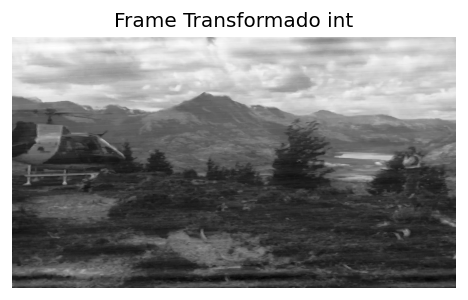

In [23]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(copy_frame_original, cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

# Transformando Frame Original

In [24]:
def transformacion(frame):
    frame_size = frame.shape
    dct_matrix = np.zeros(shape=frame_size)
    DCT2 = lambda g, norm='ortho': fft.dct(fft.dct(g, axis=0, norm=norm), axis=1, norm=norm)
    # Se recorre el frame en bloques de 8x8
    for i in range(0, frame_size[0], 8):
        for j in range(0, frame_size[1], 8):
            dct_matrix[i:(i+8),j:(j+8)] = DCT2(frame[i:(i+8),j:(j+8)])
    return dct_matrix

In [25]:
copy_frame_transformado = transformacion(copy_frame_original)

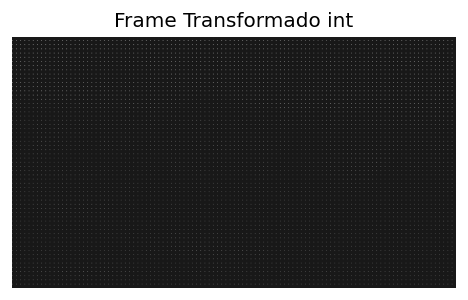

In [26]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(copy_frame_transformado, cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

# Cuantizando Frame Transformado

In [27]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

def cuantizacion(frame, porcentaje):
    frame_size = frame.shape
    frame_cuantizado = np.zeros(shape=frame_size)

    if (porcentaje < 50):
        S = 5000/porcentaje
    else:
        S = 200 - 2*porcentaje

    Q_dyn = np.floor((S*Q + 50) / 100)
    Q_dyn[Q_dyn == 0] = 1
    for i in range(0, frame_size[0], 8):
        for j in range(0, frame_size[1], 8):
            frame_cuantizado[i:(i+8), j:(j+8)] = np.round(frame[i:(i+8),j:(j+8)]/Q_dyn)
    return frame_cuantizado

In [28]:
copy_frame_cuantizado = cuantizacion(copy_frame_transformado, 90)

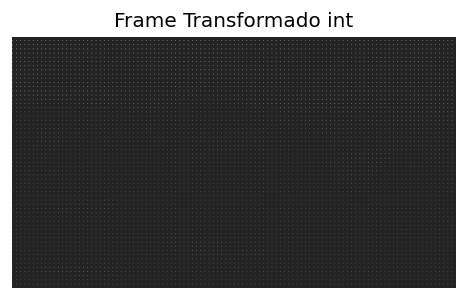

In [29]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(copy_frame_cuantizado, cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

# Transformada Inversa 

In [30]:
def inv_transform(frame):
    frame_size = frame.shape
    im_dct = np.zeros(shape=frame_size)
    IDCT2 = lambda G, norm='ortho': fft.idct( fft.idct(G, axis=0, norm=norm), axis=1, norm=norm)

    for i in range(0, frame_size[0], 8):
           for j in range(0, frame_size[1], 8): 
                im_dct[i:(i+8), j:(j+8)] = IDCT2(frame[i:(i+8),j:(j+8)])

    return np.uint8(im_dct)

In [31]:
copy_frame_inverso = inv_transform(copy_frame_cuantizado)

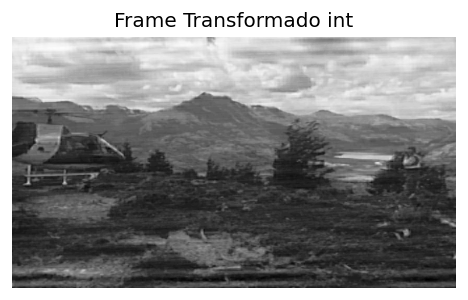

In [32]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(copy_frame_inverso, cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

In [67]:
def inv_transform(frame):
    frame_size = frame.shape
    im_dct = np.zeros(shape=frame_size)
    IDCT2 = lambda G, norm='ortho': fft.idct( fft.idct(G, axis=0, norm=norm), axis=1, norm=norm)

    for i in range(0, frame_size[0], 8):
           for j in range(0, frame_size[1], 8): 
                im_dct[i:(i+8), j:(j+8)] = IDCT2(frame[i:(i+8),j:(j+8)])

    return np.uint8(im_dct)
ultima_esperanza_frame = inv_transform(frame1.reshape(480,848))

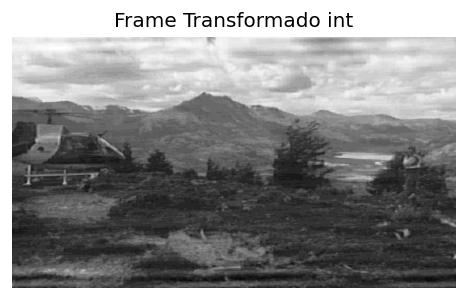

In [77]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(ultima_esperanza_frame, cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');